
# Notebook to check custom accuracy metric for water delineation

Steps: 

1. Create and vectorize classification
    - load inference raster
    - filter and clean inference
    - vectorize
    - write to .shp file
2. load hand annotation
3. project classification and annotation to calculate metric and apply buffer
    - both inputs should be wgs84 epsg:4326
4. check recall and precision of classification result


In [1]:
# set parameters:
annotation_error = 0.0 # know geolocation error of annotation dataset
buffer_size = 4.5      # accuracy treshold in meters 

# recalculate buffer zone by adding the annotation geolocation error
buffer_size = buffer_size - annotation_error

## 1. Create and vectorize classification

In [2]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape, Point
from shapely import geometry
import itertools

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

import shapely.ops as ops
import random

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union

import geopandas as gpd

from skimage import exposure
from skimage.io import imsave, imread

from tqdm.notebook import tqdm

%matplotlib inline


In [6]:
# helper functions
 
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 


def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    if rgb.mean() > 1:
        rgb[rgb > 255] = 255
    else: 
        rgb[rgb > 1] = 1
    
    return rgb

## Filter and clean inference results

## Vectorize cleaned inference results

# apply function to measure custom metric

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union, unary_union
from shapely.affinity import translate
import fiona

def custom_metric_calculation(base_name, 
                              raster_data, 
                              inference_wgs_shp, 
                              annotation_wgs_shp,
                              buffer_size,
                              verbose = 0):

    #### load data ##### 
    

    # convert list to shapely MultiPolgyons (in wgs84)
    prediction_wgs = inference_wgs_shp
    
    

    # convert list to shapely MultiPolgyons (in wgs84)
    annotation_wgs = annotation_wgs_shp

    # check dataformat to apply conversion 
    print(annotation_wgs.type)
    
    if annotation_wgs.type == 'MultiLineString':
        annotation_wgs_exterior = unary_union([poly for poly in annotation_wgs])
    elif annotation_wgs.type == 'MultiPolygon': 
        annotation_wgs_exterior = unary_union([poly.exterior for poly in annotation_wgs])
    elif annotation_wgs.type == 'Polygon':
        annotation_wgs_exterior = annotation_wgs.exterior
    else:
        annotation_wgs_exterior = unary_union([poly.exterior for poly in annotation_wgs])
        
        
    # check dataformat to apply conversion 
    if prediction_wgs.type == 'MultiLineString':
        prediction_wgs_exterior = unary_union([poly for poly in prediction_wgs])
    elif prediction_wgs.type == 'Polygon':
        prediction_wgs_exterior = prediction_wgs.exterior
    else: 
        prediction_wgs_exterior = unary_union([poly.exterior for poly in prediction_wgs])
    
    ### create projections
    
    # get vector projection 
    x,y  = prediction_wgs.centroid.xy

    epsg = wgs2epsg(x[0], y[0])

    #  EPSG:32748 is also known as WGS 84 / UTM zone 48S

    # set projections
    project_wgs2utm = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:{}'.format(epsg)))

    project_utm2wgs = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:{}'.format(epsg)), # from
        pyproj.Proj(init='epsg:4326'))            # to


    ### apply offset
    
    # sometimes a correction for geolocation inaccuracies is needed
    x_offset =  0
    y_offset =  0
    prediction_wgs = translate(prediction_wgs,xoff = x_offset, yoff = y_offset, zoff=0.0)
    
    ### project and apply buffer 
    
    # transform input data to projected coordinate system
    prediction_utm = transform(project_wgs2utm, prediction_wgs)
    
#     if len(prediction_utm) > 1:
#         prediction_utm_list = []
#         for poly in prediction_utm:
            
#             poly_boundary 
#             prediction_utm_list
            

    # create polygon by applying buffer zone and convert back to wgs84
    prediction_utm_buffer = prediction_utm.boundary.buffer(buffer_size)
    prediction_wgs_buffer_zone = transform(project_utm2wgs, prediction_utm_buffer)

    # get all necessary shapes
    annotation_utm_exterior = transform(project_wgs2utm, annotation_wgs_exterior)
    annotation_utm_buffer_zone = annotation_utm_exterior.buffer(buffer_size)
    annotation_wgs_buffer_zone = transform(project_utm2wgs, annotation_utm_buffer_zone)

    ### calculate metrics
   
    # calculate Recall 
    total_length_annotation = annotation_wgs_exterior.length
    length_overlap_prediction_annotation = prediction_wgs_buffer_zone.intersection(annotation_wgs_exterior).length
    
    if total_length_annotation == 0:
        Recall = 0
    else:
        Recall = round(length_overlap_prediction_annotation / total_length_annotation,3)

    # calculate Precision
    total_length_prediction = prediction_wgs.length
    length_overlap_detection_annotation = annotation_wgs_buffer_zone.intersection(prediction_wgs_exterior).length
    
    if total_length_prediction == 0:
        Precision = 0
    else:
        Precision = round(length_overlap_detection_annotation / total_length_prediction,3)
        
        
    if verbose > 0:
        fig = plt.figure(figsize = (10,10))

        left, bottom, right, top = raster_data.bounds
        
        left, bottom = transform(project_wgs2utm, Point(left,bottom)).xy
        right, top = transform(project_wgs2utm, Point(right, top)).xy
        
        print(left, bottom)
            
        raster_rgb = rgb_from_raster(raster_data.read(), 0.0)
        
        plt.imshow(raster_rgb, extent = (left[0], right[0], bottom[0], top[0]))

        try:
            for item in prediction_utm.boundary:
                x,y = item.xy
                plt.plot(x,y, color = 'red')
        except Exception as e:
            print(e)
            x,y = prediction_utm.boundary.xy
            plt.plot(x,y, color = 'red')
            
        try:
            for item in annotation_utm_buffer_zone.boundary:
                x,y = item.xy
                plt.plot(x,y, color = 'lightgreen', alpha = 0.5) 
        except Exception as e:
            print(e)
        
        try:
            for item in annotation_utm_buffer_zone.intersection(prediction_utm.boundary): 
                x,y = item.xy
                plt.plot(x,y, color = 'b') 
        except Exception as e:
            print(e)

        print_text = 'Precision: {} % \n Recall: {} %'.format(round(Precision * 100,3), 
                                                              round(Recall    * 100,3))
        
        plt.text(np.array(right).astype(float)-10, 
                 np.array(top).astype(float)-10, 
                 print_text, size=12, ha="right", va="top", color = 'w')
        
        plt.title(base_name)
        plt.xlabel('utm x coordinate (m)')
        plt.ylabel('utm y coordinate (m)')
        plt.axis('equal')
        plt.show()
        
#     image_save_path = "../../data/rasters_waterbodies_osm/cities/scale_test_v1/images/{}_result_image.png".format(base_name)
#     fig.savefig(image_save_path)
    
    
    return Precision, Recall

## Load annotation

In [17]:
# plot logging and results:

verbose = 0

# annotations
annotation_shapes_path = '../../data/hand_annotations/water_annotations/*.shp'# .format(name)

# find files in shapefile folder
annotation_shape_files = glob.glob(annotation_shapes_path)

print(len(annotation_shape_files))
annotation_shape_files[0:3] # = annotation_shape_files[0]



157


['../../data/hand_annotations/water_annotations/Jakarta_199_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp',
 '../../data/hand_annotations/water_annotations/Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp',
 '../../data/hand_annotations/water_annotations/Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp']

In [19]:


Precision_log = []
Recall_log = []

annotation_shape_files_cleaned = []

for annotation_file_path in tqdm(annotation_shape_files):


    base_name = '_'.join(annotation_file_path.split('/')[-1].split('_')[0:2])   # name of datasets to match
    print(base_name)

    
    # convert esri shapefiles to shapely objects
    # check valid geometries
    annotation_valid_shape_list, crs_check = check_valid_geometries(annotation_file_path)
    
    if not crs_check:
        print('crs not epsg:4623, skipping...')
        continue

    # convert list to shapely MultiPolgyons (in wgs84)
    annotation_wgs_shp = unary_union([shape(pol['geometry']) for pol in annotation_valid_shape_list])
    
    inference_match_path = "../../data/nir_green_blue/vectors/{}*.geojson".format(base_name)
    # find inference file in folder
    
    plt.figure(figsize = (10,10))
    
    
    try:
        inference_shape_files = glob.glob(inference_match_path)
        inference_file_path = inference_shape_files[0]
        df = gpd.read_file(inference_file_path)
        inference_wgs_shp = cascaded_union([shape(poly) for poly in df.geometry])
   
    except Exception as e:
        print(e)
        print('no matching inference found, skipping...')
        continue
    
    
    source_data_match_path = "../../data/source_data/{}*.tif".format(base_name)
    
    try:
        raster_shape_files = glob.glob(source_data_match_path)
        raster_file_path = raster_shape_files[0]
        
        raster_data = rasterio.open(raster_file_path)
            
    except Exception as e:
        print(e)

    if verbose > 0:
        print(annotation_file_path)
        print(inference_file_path)

    Precision, Recall = custom_metric_calculation(base_name, 
                                                  raster_data,
                                                  inference_wgs_shp,
                                                  annotation_wgs_shp,
                                                  buffer_size,
                                                  verbose)
 

    
    print('Recall    @ {}m is {}%'.format(buffer_size, round(Recall * 100,3)))
    print('Precision @ {}m is {}%'.format(buffer_size, round(Precision * 100,3)))
    
    if Precision < 0.5 or Recall < 0.5:
        remove = 'n' #input('remove? y/n')
    else:
        remove = 'n'
    
    if remove is not 'y':
        annotation_shape_files_cleaned.append(annotation_file_path)
        
    if remove is not 'y':
        Precision_log.append(Precision)
        Recall_log.append(Recall)



Jakarta_199
MultiPolygon
Recall    @ 4.5m is 96.3%
Precision @ 4.5m is 64.6%
Jakarta_255
MultiPolygon
Recall    @ 4.5m is 87.8%
Precision @ 4.5m is 92.0%
Balikpapan_025
MultiPolygon
Recall    @ 4.5m is 87.2%
Precision @ 4.5m is 77.2%
Jakarta_528
list index out of range
no matching inference found, skipping...
Medan_059
MultiPolygon
Recall    @ 4.5m is 75.3%
Precision @ 4.5m is 97.3%
Jakarta_258
MultiPolygon
Recall    @ 4.5m is 87.6%
Precision @ 4.5m is 93.0%
Denpasar_047
MultiPolygon
Recall    @ 4.5m is 99.3%
Precision @ 4.5m is 74.2%
Jakarta_150
Polygon
Recall    @ 4.5m is 100.0%
Precision @ 4.5m is 100.0%
Jakarta_198
GeometryCollection
Recall    @ 4.5m is 0%
Precision @ 4.5m is 0.0%
Jakarta_378
MultiPolygon
Recall    @ 4.5m is 98.2%
Precision @ 4.5m is 97.8%
Medan_254
MultiPolygon
Recall    @ 4.5m is 70.4%
Precision @ 4.5m is 95.2%
Medan_016
MultiPolygon
Recall    @ 4.5m is 82.0%
Precision @ 4.5m is 99.2%
Jakarta_416
MultiPolygon
Recall    @ 4.5m is 32.8%
Precision @ 4.5m is 100.0%
C

Recall    @ 4.5m is 70.5%
Precision @ 4.5m is 85.8%
Jakarta_068
Polygon
Recall    @ 4.5m is 84.5%
Precision @ 4.5m is 29.1%
Denpasar_023
MultiPolygon
Recall    @ 4.5m is 81.9%
Precision @ 4.5m is 81.8%
Cilegon_005
crs is not epsg:4326, skipping...
crs not epsg:4623, skipping...
Jakarta_034
MultiPolygon
Recall    @ 4.5m is 60.7%
Precision @ 4.5m is 69.3%
Medan_270
MultiPolygon
Recall    @ 4.5m is 89.7%
Precision @ 4.5m is 82.9%
Jakarta_239
MultiPolygon
Recall    @ 4.5m is 91.8%
Precision @ 4.5m is 91.3%
Jakarta_344
MultiPolygon
Recall    @ 4.5m is 97.9%
Precision @ 4.5m is 93.7%
Jakarta_349
MultiPolygon
Recall    @ 4.5m is 96.5%
Precision @ 4.5m is 98.7%
Jakarta_218
MultiPolygon
Recall    @ 4.5m is 94.1%
Precision @ 4.5m is 93.3%
Jakarta_298
MultiPolygon
Recall    @ 4.5m is 15.9%
Precision @ 4.5m is 6.5%
Jakarta_340
MultiPolygon
Recall    @ 4.5m is 97.1%
Precision @ 4.5m is 97.5%
Denpasar_042
MultiPolygon
Recall    @ 4.5m is 100.0%
Precision @ 4.5m is 98.3%
Jakarta_662
MultiPolygon
Reca

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [20]:
base_name

'Jakarta_237'

In [21]:
len(Recall_log)

147

In [22]:
average_recall = round(np.average(np.array(Recall_log)[np.argwhere([selection > 0 for selection in Recall_log])]), 4)
average_precision = round(np.average(np.array(Precision_log)[np.argwhere([selection > 0 for selection in Precision_log])]),4)

print('average recall: ', average_recall, '\naverage precision: ', average_precision)

average recall:  0.8048 
average precision:  0.8994


(array([ 2.,  2.,  4.,  2.,  8., 12., 15., 16., 35., 50.]),
 array([0.159 , 0.2431, 0.3272, 0.4113, 0.4954, 0.5795, 0.6636, 0.7477,
        0.8318, 0.9159, 1.    ]),
 <a list of 10 Patch objects>)

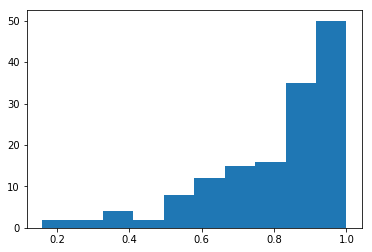

In [24]:
plt.hist(np.array(Recall_log)[np.argwhere([selection > 0 for selection in Recall_log])])

(array([ 1.,  0.,  1.,  1.,  1.,  2.,  5., 12., 29., 94.]),
 array([0.065 , 0.1585, 0.252 , 0.3455, 0.439 , 0.5325, 0.626 , 0.7195,
        0.813 , 0.9065, 1.    ]),
 <a list of 10 Patch objects>)

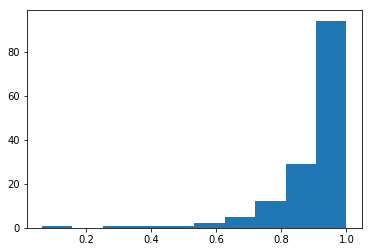

In [26]:
plt.hist(np.array(Precision_log)[np.argwhere([selection > 0 for selection in Precision_log])])